# Chainer (2)

Based on [Chainerビギナーズハンズオン資料 1](https://github.com/mitmul/chainer-handson/blob/master/1-Write-the-training-loop_ja.ipynb).

前回はVariableを作成してforward計算、backwrd計算 (backprop) までを行いました。今回は学習すべきパラメータを持つモデルを作成し、データを与えて訓練してみます。

neural networkにはさまざまなモデルがありますが、今回は単純なfeedforward networkを実装します。

学習の仕方は大きく (1) 教師あり学習、(2) 教師なし学習、(3) 半教師あり学習に分類できます。今回扱うのは教師あり学習です。教師あり学習では、入力 $x$ と出力 $y$ のペアを考えたとき、$y = f(x; \theta)$ となる (に近づく) ようにパラメータ $\theta$ を調整します。

教師あり学習は、訓練とテストの2つのフェーズからなります。__訓練__時には訓練データをモデルに与え、モデルのパラメータを学習します。__テスト (評価) __時には、入力 $x$ がモデルに与えられ、モデルは出力 $y^\prime$ を予想します。モデルの出力 $y^\prime$ と正解 $y$ がどれくらい一致しているかを見ることで、モデルの性能を評価します。

訓練とテストに使うデータはわけておきます。訓練データに対する精度が高く、テストデータに対する精度が低い場合は、モデルが__過学習__を起こしていることになります。未知のテストデータにおいても高い精度を実現する、汎化性能の高いモデルを学習したいところです。

事前に指定し、データからは学習されないパラメータ (__ハイパーパラメータ__) をどう選ぶのか、あるいは学習をどこで打ち切るかといった問題は、訓練データだけでは決められません。そこで、訓練データ、テストデータに加えて、__開発 (development/validation) データ__を用意することがよくあります。モデル変種を開発データに適用し、精度がもっとも高くなるものを選択します。

In [1]:
# モジュール一式のimport
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

## データセットの準備

今回は手描き数値認識データセットMNISTを使います。入力は数値の画像、出力は0-9のいずれかです。

データの入手にはChainerが用意しているメソッドを利用します。このメソッドはデータのダウンロードし、一つ一つのデータを取り出してくれます。

自分が解きたい問題に対しては、同様の処理を自分で用意する必要があります。

In [2]:
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# データセットの事例数
# ここでは訓練データ (train)、テストデータ (test) の2個だけです
# 以下では、test を開発データとして使うので注意が必要です
len(train), len(test)

(60000, 10000)

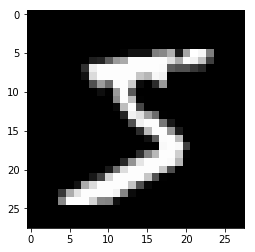

label: 5


In [3]:
# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

x, t = train[0] # 1個の事例
# 入力は 784 (28x28) 個の要素からなる実数列、出力は 0-9 のいずれかのラベル
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

## Iteratorの作成

教師あり学習の手法には、バッチ学習とオンライン学習の2種類があります。バッチ学習は、データを全部読んでモデルを更新します。オンライン学習は、典型的には1個の事例を読んでモデルを更新します。両者の折衷的な手法がミニバッチを用いるもので、近年のneural networkの学習ではこれが標準化しています。バッチ学習は訓練が遅い、オンライン学習は1個の事例しか使わないので更新がノイジーという問題がありますが、これらの問題はミニバッチを用いると緩和されます。また、GPUを用いた並列計算との相性の良さもミニバッチの利点です。

データセットはIteratorクラスのオブジェクトに与えます。Iteratorは、next()を呼び出すごとに、データセットから指定されたサイズのミニバッチを作って返します。内部ではデータセットを何周なめたか（epoch）、現在のイテレーションが新しいepochの最初のイテレーションか、などを管理するプロパティ（is_new_epoch）などを持っています。

In [4]:
batchsize = 128 # minibatchのサイズ

# デフォルトでデータセット内の事例をshuffleする
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

### Iteratorについて

* Iteratorは Chainer v1.11.0 で導入されたもので、以前からの利用者は同様の処理を自分で書いていました。
* Chainerがいくつか用意しているIteratorの一種であるSerialIteratorは、データセットの中のデータを順番に取り出してくる最もシンプルなIteratorです。
* 引数にデータセットオブジェクトと、バッチサイズを取ります。
* また、このとき渡したデータセットから、何周も何周もデータを繰り返し読み出す必要がある場合はrepeat引数をTrueとし、1周が終わったらそれ以上データを取り出したくない場合はこれをFalseとします。デフォルトでは、Trueになっています。
* shuffle引数にTrueを渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。

ここで、batchsize = 128としているので、ここで作成した訓練データ用のIteratorであるtrain_iterおよびテストデータ用のIteratorであるtest_iterは、それぞれ128枚の数字画像データを一括りにして返すIteratorということになります。

## モデルの定義

ここでは、シンプルな3層パーセプトロンを定義します。これは全結合層のみからなるネットワークです。中間層のユニット数は適当に100とし、出力は10クラスなので10とします。ここで用いるMNISTデータセットは10種のラベルを持つためです。では、モデルを定義するために必要なLink, Function, そしてChainについて、簡単にここで説明を行います。

### LinkとFunction

* Chainerでは、ニューラルネットワークの各層を、LinkとFunctionに区別します。
* Linkは、パラメータを持つ関数です。
* Functionは、パラメータを持たない関数です。
* これらを組み合わせてモデルを記述します。
* パラメータを持つ層は、chainer.linksモジュール以下にたくさん用意されています。
* パラメータを持たない層は、chainer.functionsモジュール以下にたくさん用意されています。
* これらを簡単に使うために、

    ```
    import chainer.links as L
    import chainer.functions as F
    ```
    と別名を与えて、L.Convolution2D(...)やF.relu(...)のように用いる慣習があります。

### Chain

* Chainは、パラメータを持つ層＝Linkをまとめておくためのクラスです。
* パラメータを持つということは、基本的にモデルの学習の際にそれらを更新していく必要があるということです（例外はあります）。
* そこで、学習中にOptimizerが更新すべき全てのパラメータを簡単に取得できるように、Chainで一箇所にまとめておきます。

### Chainを継承して定義されるモデル

* モデルはChainクラスを継承したクラスとして定義されることが多いです。
* その場合、モデルを表すクラスのコンストラクタで、親クラスのコンストラクタにキーワード引数の形で登録したい層の名前と、オブジェクトを渡しておくと、自動的にOptimizerから見つけられる形で保持しておいてくれます。
* これは、別の場所でadd_linkメソッドを使っても行うことができます。
* また、関数呼び出しのようにしてモデルに()アクセサでデータを渡せるように、__call__メソッドを定義して、その中にforward処理を記述すると便利です。

In [5]:
class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # パラメータを持つ層の登録
        super(MLP, self).__init__(
            # Linear は W x + b の線形変換 (全結合) を行うLink
            # 第1引数は入力の次元数 (Noneの場合は、初回呼び出し時にデータから自動的に推測)
            # 第2引数は出力の次元数
            l1=L.Linear(None, n_mid_units),
            l2=L.Linear(None, n_mid_units),
            l3=L.Linear(None, n_out),
        )

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        # relu は Rectified Linear Unit: f(x)=max(0,x)
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

# gpu_id = 0

model = MLP()
# model.to_gpu(gpu_id)

ここで、L.Linearクラスは全結合層を意味します。コンストラクタの第一引数にNoneを渡すと、実行時に、データがその層に入力された瞬間、必要な数の入力側ユニット数を自動的に計算し、(n_input) $\times$ n_mid_unitsの大きさの行列を作成し、パラメータとして保持します。これは後々、畳み込み層を全結合層の前に配置する際などに便利な機能です。

前述のように、Linkはパラメータを持つので、そのパラメータの値にアクセスすることができます。例えば、上のモデルMLPはl1という名前の全結合層が登録されています。この全結合層はWとbという2つのパラメータを持ちます。

In [6]:
print('1つ目の全結合相のバイアスパラメータの形は、', model.l1.b.shape)
print('初期化直後のその値は、', model.l1.b.data)

1つ目の全結合相のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


## 最適化手法の選択

Chainerは多くの最適化手法を提供しています。chainer.optimizersモジュール以下にそれらはあります。ここではもっともシンプルな勾配降下法の手法であるoptimizers.SGDを用います。Optimizerのオブジェクトには、setupメソッドを使ってモデル（Chainオブジェクト）を渡します。こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的にたどってくれます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下のchainer.optimizers.SGDのうちSGDの部分をMomentumSGD, RMSprop, Adamなどに変えて、結果の違いを見てみましょう。

In [7]:
optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)

今回はSGDのコンストラクタのlrという引数に $0.01$ を与えました。この値は学習率として知られ、モデルをうまく訓練して良いパフォーマンスを発揮させるために調整する必要がある重要なハイパーパラメータとして知られています。

## 学習ループ

いよいよ学習ループです。今回は分類問題なので、softmax_cross_entropyというロス関数を使って最小化すべきロスの値を計算します。

Chainerでは、FunctionやLinkを使ってモデルのforward計算を行い、結果と正解ラベルをFunctionの一種でありスカラ値を返すロス関数に渡してやり、ロスの計算を行うと、それは他のLinkやFunctionと同じく、Variableオブジェクトを返します。Variableオブジェクトはこれまでの計算過程をあとから逆向きに辿り返すための参照を保持しているため、Variable.backwardメソッドを呼ぶだけで、自動的にそこからこれまでの計算過程をさかのぼって、途中で施された計算に用いられたパラメータの勾配を計算してくれます。

つまり、学習ループの1回の中で行うのは、以下の4項目です。

1. モデルにデータを渡して出力yを得る
2. yと正解ラベルtを使って、最小化すべきロスの値をsoftmax_cross_entropy関数で計算する
3. softmax_cross_entropy関数の出力Variableのbackwardメソッドを呼んで、モデル内部のパラメータにgradプロパティ（これがパラメータ更新に使われる勾配）を持たせる
4. Optimizerのupdateメソッドを呼び、3.で計算したgradを使って全パラメータを更新する

以上です。では実際に訓練ループを書いていきます。

In [8]:
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:
    
    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    # minibatch の事例列を連結して配列にします
    x, t = concat_examples(train_batch)
    x = Variable(x) # (128, 784)
    t = Variable(t) # (128,)
    
    # 予測値の計算
    y = model(x) # (128, 10)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    model.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            x_test, t_test = concat_examples(test_batch)

            # テストデータをforward
            y_test = model(x_test)

            # ロスを計算
            loss_test = F.softmax_cross_entropy(y_test, t_test)
            test_losses.append(to_cpu(loss_test.data))

            # 精度を計算
            accuracy = F.accuracy(y_test, t_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)
            
            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.6897 val_loss:0.7200 val_accuracy:0.8327
epoch:02 train_loss:0.4485 val_loss:0.4453 val_accuracy:0.8792
epoch:03 train_loss:0.4534 val_loss:0.3688 val_accuracy:0.8971
epoch:04 train_loss:0.2295 val_loss:0.3312 val_accuracy:0.9047
epoch:05 train_loss:0.2718 val_loss:0.3096 val_accuracy:0.9115
epoch:06 train_loss:0.3797 val_loss:0.2920 val_accuracy:0.9171
epoch:07 train_loss:0.1930 val_loss:0.2769 val_accuracy:0.9210
epoch:08 train_loss:0.2813 val_loss:0.2665 val_accuracy:0.9245
epoch:09 train_loss:0.2217 val_loss:0.2569 val_accuracy:0.9288
epoch:10 train_loss:0.3169 val_loss:0.2487 val_accuracy:0.9299


## 学習済みモデルを保存する

Chainerには2つのシリアライズ機能が用意されています。一つはHDF5形式でモデルを保存するもので、もう一つはNumPyのNPZ形式でモデルを保存するものです。今回は、追加ライブラリのインストールが必要なHDF5ではなく、NumPy標準機能で提供されているシリアライズ機能を利用したNPZ形式でのモデルの保存を行います。

In [9]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# ちゃんと保存されていることを確認
%ls -la my_mnist.model

-rw-rw-r-- 1 murawaki murawaki 333930  5月 11 17:10 my_mnist.model


## 保存したモデルを読み込んで推論する

今しがた保存したNPZファイルを読み込んで、テストデータに対して予測を計算させてみます。NPZファイルにはパラメータが保存されているので、forward計算のロジックを持つモデルのオブジェクトをまず作成し、そのパラメータを先程保存したNPZが持つ値で上書きすることで学習直後のモデルの状態を復元します。

In [10]:
# まず同じモデルのオブジェクトを作る
infer_model = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_model)

# GPU上で計算させるために、モデルをGPUに送る
# infer_model.to_gpu(gpu_id)

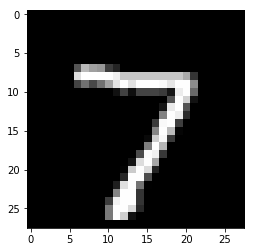

label: 7


In [11]:
# テストデータ
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

In [12]:
# ミニバッチの形にする（ここではサイズ1のミニバッチにするが、
# 複数まとめてサイズnのミニバッチにしてまとめて推論することもできる）
print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# モデルのforward関数に渡す
y = infer_model(x)

# Variable形式で出てくるので中身を取り出す
y_data = y.data

# 最大値のインデックスを見る
pred_label = y_data.argmax(axis=1)

print('predicted label:', pred_label[0])

(784,) -> (1, 784)
predicted label: 7


## 課題

* 今回作ったMLPをいじって精度を上げてください。中間層を増やす/減らす、活性化関数としてrelu以外のものを使う、パラメータの初期値を変える、Optimizerやそのハイパーパラメータを変えるなど。
* MNISTは精度99%を達成してあたりまえのデータセットです。また、ベンチマークとして標準的地位を確立しており、様々なモデルがgithub等で公開されています。convolutional neural network (CNN) など別のモデルを試してみてください。